In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd 'drive/My Drive/CSE842 Project/SemEval2018-Task1-all-data/SemEval2018-Task1-all-data/English/E-c'

/content/drive/My Drive/CSE842 Project/SemEval2018-Task1-all-data/SemEval2018-Task1-all-data/English/E-c


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import re
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, jaccard_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [5]:
df = pd.read_csv('2018-E-c-En-train.txt', sep='\t', on_bad_lines='skip', nrows=500)
df = df.drop(columns=['ID'])
df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,That feeling you get when you know the informa...,0,0,0,1,0,0,0,1,1,0,0
496,@WriterlyTweets Supine on the piano—lips parte...,0,0,0,0,1,0,0,0,0,0,0
497,Watching It Follows. This is a super freaky m...,0,0,0,1,0,0,0,0,0,1,0
498,"The best revenge is to move on, get over it, a...",0,0,0,0,1,0,1,0,0,0,0


In [6]:
def checkTweet(text, token):
    num = 0
    for word in text.split():
        if re.search(token, word):
            num += 1
    return num

In [7]:
df['hashtag'] = df['Tweet'].apply(lambda x: checkTweet(x, '^#'))
df['mention'] = df['Tweet'].apply(lambda x: checkTweet(x, '^@'))
df['url'] = df['Tweet'].apply(lambda x: checkTweet(x, '^http'))

print(f"Total # of hashtags: {np.sum(df['hashtag'])}")
print(f"Total # of mentions: {np.sum(df['mention'])}")
print(f"Total # of urls: {np.sum(df['url'])}")
df

Total # of hashtags: 463
Total # of mentions: 298
Total # of urls: 0


,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,hashtag,mention,url
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1,3,0,0
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,1,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0,1,1,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,That feeling you get when you know the informa...,0,0,0,1,0,0,0,1,1,0,0,2,0,0
496,@WriterlyTweets Supine on the piano—lips parte...,0,0,0,0,1,0,0,0,0,0,0,4,1,0
497,Watching It Follows. This is a super freaky m...,0,0,0,1,0,0,0,0,0,1,0,2,0,0
498,"The best revenge is to move on, get over it, a...",0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
def preprocess_with_spacy(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', '', text)
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
    tokens = [token if token != '.' else ' ' for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [10]:
df['Tweet'] = df['Tweet'].apply(preprocess_with_spacy)
df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,hashtag,mention,url
0,worry is a down payment on a problem you may n...,0,1,0,0,0,0,1,0,0,0,1,3,0,0
1,whatever you decide to do make sure it makes you,0,0,0,0,1,1,1,0,0,0,0,1,0,0
2,it also helps that the majority of nfl coachin...,1,0,1,0,1,0,1,0,0,0,0,1,1,0
3,accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,my roommate it 's okay that we ca n't spell be...,1,0,1,0,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,that feeling you get when you know the informa...,0,0,0,1,0,0,0,1,1,0,0,2,0,0
496,supine on the piano lips parted,0,0,0,0,1,0,0,0,0,0,0,4,1,0
497,watching it follows this is a super freaky movie,0,0,0,1,0,0,0,0,0,1,0,2,0,0
498,the best revenge is to move on get over it and...,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [11]:
tweets = df['Tweet']
new_fearutes = np.column_stack((df['hashtag'], df['mention']))
new_fearutes = csr_matrix(new_fearutes)
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X = count_vectorizer.fit_transform(tweets)
Y = df.drop(columns=['Tweet', 'hashtag', 'mention', 'url'])
X_new = hstack((X, new_fearutes))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2, random_state=42)

In [13]:
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train.shape)

torch.Size([400, 5516])
torch.Size([100, 5516])
(400, 11)


In [14]:
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

print(y_train_tensor.shape)

torch.Size([400, 11])


In [15]:
df2 = pd.read_csv('2018-E-c-En-test-gold.txt', sep='\t', on_bad_lines='skip')
df2 = df2.drop(columns=['ID'])
df2

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,1,0,0,0,0,1,0,0,0,1
1,"Academy of Sciences, eschews the normally sobe...",0,0,1,0,0,0,0,0,0,0,0
2,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0
3,This time in 2 weeks I will be 30... 😥,0,0,0,0,1,0,0,0,1,0,0
4,#Deppression is real. Partners w/ #depressed p...,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,shaft abrasions from panties merely shifted to...,1,0,0,0,0,0,0,1,0,0,0
3255,@lomadia heard of Remothered? Indie horror gam...,0,1,0,0,0,0,0,1,0,0,0
3256,All this fake outrage. Y'all need to stop 🤣,1,0,1,0,0,0,0,0,0,0,0
3257,Would be ever so grateful if you could record ...,0,0,0,0,1,0,0,0,0,0,0


In [16]:
df2['hashtag'] = df2['Tweet'].apply(lambda x: checkTweet(x, '^#'))
df2['mention'] = df2['Tweet'].apply(lambda x: checkTweet(x, '^@'))
df2['url'] = df2['Tweet'].apply(lambda x: checkTweet(x, '^http'))
df2

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,hashtag,mention,url
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,1,0,0,0,0,1,0,0,0,1,0,2,0
1,"Academy of Sciences, eschews the normally sobe...",0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0,1,0,0
3,This time in 2 weeks I will be 30... 😥,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,#Deppression is real. Partners w/ #depressed p...,0,0,0,1,0,0,0,0,1,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,shaft abrasions from panties merely shifted to...,1,0,0,0,0,0,0,1,0,0,0,2,0,0
3255,@lomadia heard of Remothered? Indie horror gam...,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3256,All this fake outrage. Y'all need to stop 🤣,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3257,Would be ever so grateful if you could record ...,0,0,0,0,1,0,0,0,0,0,0,1,2,0


In [17]:
df2['Tweet'] = df2['Tweet'].apply(preprocess_with_spacy)

In [18]:
tweets = df2['Tweet']
X_gold = count_vectorizer.transform(tweets)
y_gold = df2.drop(columns=['Tweet', 'hashtag', 'mention', 'url'])

new_fearutes2 = np.column_stack((df2['hashtag'], df2['mention']))
new_fearutes2 = csr_matrix(new_fearutes2)
X_gold_new = hstack((X_gold, new_fearutes2))

print(X_gold.shape)
print(X_gold_new.shape)
print(y_gold.shape)
df2['mention'].isna().sum()

(3259, 5514)
(3259, 5516)
(3259, 11)


0

In [19]:
X_test_gold = csr_matrix(X_gold_new).toarray()
X_gold_tensor = torch.tensor(X_test_gold, dtype=torch.float32)

y_gold_tensor = torch.tensor(y_gold.to_numpy(), dtype=torch.float32)

In [20]:
def MultiLabelAccuracy(pred_vals, real_vals):
    ML_accur = 0
    for row1, row2 in zip(pred_vals, real_vals):
        if len(row1) != len(row2):
            print("Rows are not the same length:")
            print(row1)
            print(row2)
        num_correct = 0
        num_labels = 0
        for i in range(len(row1)):
            if row1[i] == 1:
                num_labels += 1
            if row2[i] == 1:
                if row1[i] == row2[i]:
                    num_correct += 1
                else:
                    num_labels += 1


        intersection_size = num_correct
        # union_size = len(row1) + len(row2) - num_correct
        union_size = num_labels
        if intersection_size == 0 or union_size == 0:
            row_accur = 0
        else:
            row_accur = intersection_size / union_size
        ML_accur += row_accur
        # print(intersection_size)
        # print(union_size)
    # print(len(pred_vals))
    # print(ML_accur)
    return ML_accur / len(pred_vals)

In [21]:
def MacroF1(pred_vals, real_vals):
    num_classes = len(pred_vals[0])
    correct = [0] * num_classes
    num_assigned = [0] * num_classes
    num_in_class = [0] * num_classes
    for row1, row2 in zip(pred_vals, real_vals):
        for i in range(num_classes):
            if row1[i] == 1:
                if row1[i] == row2[i]:
                    correct[i] += 1
                    num_assigned[i] += 1
                else:
                    num_assigned[i] += 1
            if row2[i] == 1:
                num_in_class[i] += 1
    macroF1 = 0
    for i in range(num_classes):
        if num_assigned[i] == 0:
            precision = 0
        else:
            precision = correct[i] / num_assigned[i]
        if num_in_class[i] == 0:
            recall = 0
        else:
            recall = correct[i] / num_in_class[i]
        if precision + recall == 0:
            F = 0
        else:
            F = (2 * precision * recall) / (precision + recall)
        macroF1 += F
    return macroF1 / num_classes

In [22]:
def ThresholdFineTuning(regr_pred):
    top_jaccard = [0,0]  # threshold, output value
    top_microF1 = [0,0]  # threshold, output value
    top_macroF1 = [0,0]  # threshold, output value

    cur_thresh = 0
    max_thresh = 0.5
    increment = 0.01

    pbar = tqdm(total=max_thresh)
    while cur_thresh <= max_thresh:
        temp_y_pred = np.copy(regr_pred)
        temp_y_pred[temp_y_pred > cur_thresh] = 1
        temp_y_pred[temp_y_pred <= cur_thresh] = 0

        temp_jaccard = jaccard_score(y_test.to_numpy(), temp_y_pred, average="samples", zero_division=0)

        temp_report = classification_report(y_test, temp_y_pred, output_dict=True, zero_division=0)
        temp_micro = temp_report['micro avg']['f1-score']
        temp_macro = temp_report['macro avg']['f1-score']

        if temp_jaccard > top_jaccard[1]:
            top_jaccard = [cur_thresh, temp_jaccard]
        if temp_micro > top_microF1[1]:
            top_microF1 = [cur_thresh, temp_micro]
        if temp_macro > top_macroF1[1]:
            top_macroF1 = [cur_thresh, temp_macro]

        cur_thresh += increment
        pbar.update(increment)

    print(top_jaccard)
    print(top_microF1)
    print(top_macroF1)
    optimal_threshold = top_jaccard[0]
    return optimal_threshold

In [23]:
class MultiLabelClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiLabelClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [24]:
# define the input and output sizes based on data
input_size = X_train_tensor.shape[1]
hidden_size = 50
num_classes = y_train_tensor.shape[1]

# instantiate the model
model = MultiLabelClassificationModel(input_size, hidden_size, num_classes)

print(input_size)
print(num_classes)

5516
11


In [25]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
num_epochs = 100

loss_history = []

for epoch in tqdm(range(num_epochs), desc='Training Progress'):

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

print('Training complete')

Training Progress: 100%|██████████| 100/100 [00:02<00:00, 45.48it/s]

Training complete


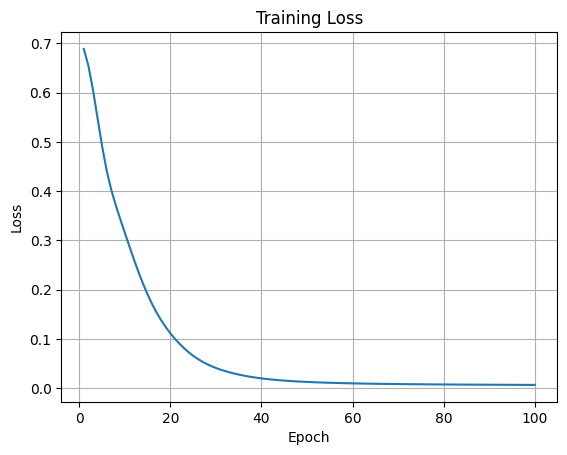

In [27]:
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

In [28]:
model.eval()

num_correct = 0
num_samples = 0

with torch.no_grad():
    y_pred = model(X_test_tensor)
    nn_predicted = (y_pred > 0.5).float()
    predicted = (y_pred > 0.4).float()

    num_correct += (predicted == y_test_tensor).sum().item()
    num_samples += y_test_tensor.numel()

accuracy = num_correct / num_samples
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
MLA = MultiLabelAccuracy(nn_predicted, y_test_tensor)
print("Multi-label Accuracy on test set: ", MLA)


Accuracy on the test set: 78.64%
Multi-label Accuracy on test set:  0.127


In [29]:
model.eval()

with torch.no_grad():
    y_pred_gold = model(X_gold_tensor)

In [30]:
nn_thresh = ThresholdFineTuning(nn_predicted)
print("Threshold: ", nn_thresh)

 88%|████████▊ | 0.4400000000000002/0.5 [00:00<00:00,  2.07s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.5000000000000002/0.5 [00:01<00:00,  2.07s/it]

[0, 0.127]
[0, 0.20833333333333334]
[0, 0.102158811862193]
Threshold:  0


In [31]:
nn_pred_gold = y_pred_gold[:]
nn_pred_gold[nn_pred_gold > nn_thresh] = 1
nn_pred_gold[nn_pred_gold <= nn_thresh] = 0
nn_pred_gold

nn_jaccard = jaccard_score(y_gold, nn_pred_gold, average="samples")
print(nn_jaccard)
nn_report = classification_report(y_gold, nn_pred_gold, output_dict=True)
print(classification_report(y_gold, nn_pred_gold))

0.21950403079583808
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      1101
           1       0.13      1.00      0.23       425
           2       0.34      1.00      0.50      1099
           3       0.15      1.00      0.26       485
           4       0.44      1.00      0.61      1442
           5       0.16      1.00      0.27       516
           6       0.35      1.00      0.52      1143
           7       0.12      1.00      0.21       375
           8       0.29      1.00      0.46       960
           9       0.05      1.00      0.10       170
          10       0.05      1.00      0.09       153

   micro avg       0.22      1.00      0.36      7869
   macro avg       0.22      1.00      0.34      7869
weighted avg       0.30      1.00      0.44      7869
 samples avg       0.22      0.98      0.35      7869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample", random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [33]:
rf_y_pred = rf_classifier.predict(X_test)

In [34]:
rf_MLA = MultiLabelAccuracy(rf_y_pred, y_test.to_numpy())
print(rf_MLA)
rf_class_report = classification_report(y_test, rf_y_pred, output_dict=True)
print("Classification Report for Random Forest (Test Set): \n", classification_report(y_test, rf_y_pred))

0.1175
Classification Report for Random Forest (Test Set): 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00        14
           4       0.51      0.45      0.48        44
           5       0.00      0.00      0.00        16
           6       1.00      0.05      0.10        37
           7       0.00      0.00      0.00        10
           8       0.38      0.14      0.20        22
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         6

   micro avg       0.51      0.11      0.18       231
   macro avg       0.17      0.06      0.07       231
weighted avg       0.29      0.11      0.13       231
 samples avg       0.23      0.12      0.15       231



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [35]:
rf_y_pred_gold = rf_classifier.predict(X_test_gold)

In [36]:
rf_MLA_gold = MultiLabelAccuracy(rf_y_pred_gold, y_gold.to_numpy())
print(rf_MLA_gold)
macroF1 = MacroF1(rf_y_pred_gold, y_gold.to_numpy())
print(macroF1)
rf_class_jaccard = jaccard_score(y_gold, rf_y_pred_gold, average="samples")
print("jaccard_score: ", rf_class_jaccard)
print("Classification Report for Random Forest (Gold Set): \n", classification_report(y_gold, rf_y_pred_gold))

0.08816610412191879
0.05139120416453768
jaccard_score:  0.08816610412191879
Classification Report for Random Forest (Gold Set): 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1101
           1       0.00      0.00      0.00       425
           2       0.43      0.00      0.01      1099
           3       0.00      0.00      0.00       485
           4       0.46      0.39      0.42      1442
           5       1.00      0.00      0.00       516
           6       1.00      0.00      0.01      1143
           7       0.22      0.01      0.01       375
           8       0.31      0.07      0.12       960
           9       0.00      0.00      0.00       170
          10       0.00      0.00      0.00       153

   micro avg       0.44      0.08      0.14      7869
   macro avg       0.31      0.04      0.05      7869
weighted avg       0.40      0.08      0.09      7869
 samples avg       0.20      0.09      0.12      7869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=42)

rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [38]:
rf_regr_pred = rf_regressor.predict(X_test_gold)
rf_regr_pred

array([[0.62, 0.06, 0.62, ..., 0.07, 0.02, 0.  ],
       [0.63, 0.  , 0.63, ..., 0.07, 0.  , 0.  ],
       [0.38, 0.  , 0.38, ..., 0.53, 0.  , 0.  ],
       ...,
       [0.67, 0.  , 0.55, ..., 0.07, 0.  , 0.  ],
       [0.72, 0.11, 0.78, ..., 0.08, 0.08, 0.09],
       [0.64, 0.  , 0.64, ..., 0.06, 0.  , 0.  ]])

In [39]:
rf_y_pred = rf_regressor.predict(X_test)
rf_regr_thresh = ThresholdFineTuning(rf_y_pred)
print(rf_regr_thresh)

rf_regr_pred = rf_regressor.predict(X_test_gold)
rf_regr_pred_gold = rf_regr_pred[:]
rf_regr_pred_gold[rf_regr_pred > rf_regr_thresh] = 1
rf_regr_pred_gold[rf_regr_pred <= rf_regr_thresh] = 0
rf_regr_pred_gold

rf_regr_MLA = MultiLabelAccuracy(rf_regr_pred_gold, y_gold.to_numpy())
rf_regr_jacccard = jaccard_score(y_gold, rf_regr_pred_gold, average="samples")
rf_regr_report = classification_report(y_gold, rf_regr_pred_gold, output_dict=True)
print("MLA: ", rf_regr_MLA)
print("Jaccard: ", rf_regr_jacccard)
print(classification_report(y_gold, rf_regr_pred_gold))

 94%|█████████▍| 0.47000000000000025/0.5 [00:00<00:00,  1.40s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.5000000000000002/0.5 [00:00<00:00,  1.42s/it] 


[0.10999999999999999, 0.31248809523809523]
[0.13999999999999999, 0.4422442244224422]
[0, 0.33804582280827983]
0.10999999999999999
MLA:  0.30306757355698866
Jaccard:  0.3030675735569875
              precision    recall  f1-score   support

           0       0.35      0.95      0.51      1101
           1       0.16      0.12      0.14       425
           2       0.35      0.95      0.51      1099
           3       0.18      0.16      0.17       485
           4       0.44      0.84      0.58      1442
           5       0.22      0.17      0.19       516
           6       0.40      0.61      0.49      1143
           7       0.14      0.28      0.19       375
           8       0.30      0.39      0.34       960
           9       0.02      0.01      0.01       170
          10       0.07      0.02      0.03       153

   micro avg       0.34      0.60      0.44      7869
   macro avg       0.24      0.41      0.29      7869
weighted avg       0.32      0.60      0.40      7869
 sa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

svr_regressor = SVR(verbose=True)
multi_svr = MultiOutputRegressor(svr_regressor)
multi_svr.fit(X_train, y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

MultiOutputRegressor(estimator=SVR(verbose=True))

In [41]:
multi_svr_y_pred = multi_svr.predict(X_test)
multi_svr_thresh = ThresholdFineTuning(multi_svr_y_pred)
print("Optimal Threshold: ", multi_svr_thresh)

multi_svr_pred = multi_svr.predict(X_test_gold)
multi_svr_pred_gold = multi_svr_pred[:]
multi_svr_pred_gold[multi_svr_pred_gold > multi_svr_thresh] = 1
multi_svr_pred_gold[multi_svr_pred_gold <= multi_svr_thresh] = 0

multi_svr_MLA = MultiLabelAccuracy(multi_svr_pred_gold, y_gold.to_numpy())
multi_svr_jaccard = jaccard_score(y_gold, multi_svr_pred_gold, average="samples")
multi_svr_report = classification_report(y_gold, multi_svr_pred_gold, output_dict=True)
print("MLA: ", multi_svr_MLA)
print("Jaccard: ", multi_svr_jaccard)
print(classification_report(y_gold, multi_svr_pred_gold))

 84%|████████▍ | 0.4200000000000002/0.5 [00:00<00:00,  1.47s/it] /usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.5000000000000002/0.5 [00:00<00:00,  1.48s/it]


[0.3100000000000001, 0.3128333333333334]
[0.3100000000000001, 0.4559068219633944]
[0, 0.3289179687627907]
Optimal Threshold:  0.3100000000000001
MLA:  0.233572597495581
Jaccard:  0.23357259749558
              precision    recall  f1-score   support

           0       0.40      0.17      0.24      1101
           1       0.16      0.01      0.01       425
           2       0.34      0.08      0.12      1099
           3       0.14      0.02      0.04       485
           4       0.45      0.94      0.61      1442
           5       0.20      0.04      0.06       516
           6       0.45      0.29      0.35      1143
           7       0.08      0.01      0.01       375
           8       0.32      0.06      0.10       960
           9       0.00      0.00      0.00       170
          10       0.00      0.00      0.00       153

   micro avg       0.42      0.26      0.32      7869
   macro avg       0.23      0.15      0.14      7869
weighted avg       0.32      0.26      0.23   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344

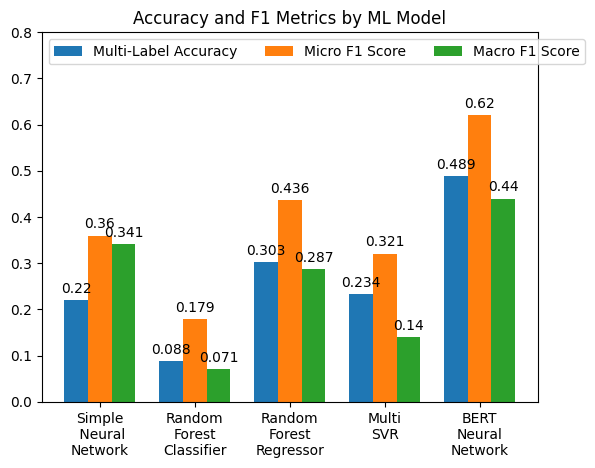

In [42]:
models = ["Simple\n Neural\nNetwork", "Random\nForest\nClassifier", "Random\nForest\nRegressor", "Multi\nSVR", "BERT\nNeural\nNetwork"]

graph_data = {
    'Multi-Label Accuracy': (round(nn_jaccard, 3), round(rf_class_jaccard, 3), round(rf_regr_jacccard, 3), round(multi_svr_jaccard, 3), 0.489),
    'Micro F1 Score':(round(nn_report['micro avg']['f1-score'], 3),
                      round(rf_class_report['micro avg']['f1-score'], 3),
                      round(rf_regr_report['micro avg']['f1-score'], 3),
                      round(multi_svr_report['micro avg']['f1-score'], 3),
                      0.62,
                      ),
    'Macro F1 Score': (round(nn_report['macro avg']['f1-score'], 3),
                       round(rf_class_report['macro avg']['f1-score'], 3),
                       round(rf_regr_report['macro avg']['f1-score'], 3),
                       round(multi_svr_report['macro avg']['f1-score'], 3),
                       0.44
                       ),
}

fig, ax = plt.subplots()

x = np.arange(len(models))
width = .25
multiplier = 0

for attribute, measurement in graph_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Accuracy and F1 Metrics by ML Model')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, .8)

plt.show()

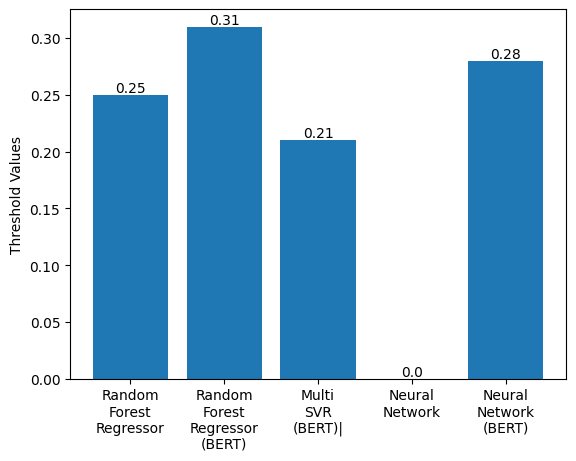

In [47]:
models = ["Random\nForest\nRegressor", "Random\nForest\nRegressor\n(BERT)", "Multi\nSVR\n(BERT)|", "Neural\nNetwork", "Neural\nNetwork\n(BERT)"]

data = (0.25, 0.31, 0.21, 0, 0.28)

fig, ax = plt.subplots()
bars = ax.bar(models, data)

ax.set_ylabel('Threshold Values')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()